# TP: Segmentación
***
+ Objetivos: obtener la mejor segmentación de los bloques respecto del resto de piezas, para ello planteamos 3 métodos:
    
    1. Watersheed: La idea del método es segmentar la imagen en varios "cuencos" acumuladores, luego comenzar a inundar el paisaje en todos los mínimos locales y comenzar a etiquetar bordes a medida que las áreas(cuencos) de agua distinta comienza a juntarse. Se utiliza generalmente como un algoritmo de precomputación de la segmentación.
    
    2. Mean shift: Busca los máximos locales de las densidades en el espacio de características. 
    
    3. K-means: Inicializa arbitrariamente los centros de los clústers (previamente definidos) y determina los puntos correspondientes a cada clúster.
    
   

In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# En caso de usar el ploteo sin el inline utilizar plt.figure() en vez de plt.title() 
# de manera tal que sea más clara las ventanas de las imagenes.

### Leemos la imagen 

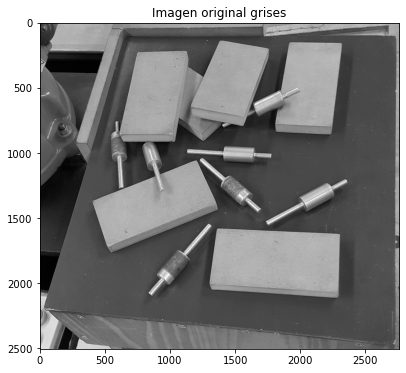

In [2]:
#cargamos la imagen
img=cv.imread("bloques.png")
img_gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)

#plt.figure("Imagen original grises")
plt.figure(figsize=(8,6))
plt.title("Imagen original grises")
plt.imshow(img_gray,cmap="gray")
plt.show()

## Tranformacion geometrica

* Debido al ángulo de perpectiva que presenta la imagen planteamos una transformación geométrica proyectiva, de manera que podamos analizar (si bien con alguna distorción) de mejor manera la situación de los bloques con una perspectiva superior de los mismos. Para ellos definimos 4 puntos a transformar siendo estos las 4 esquinas superiores del tablero.

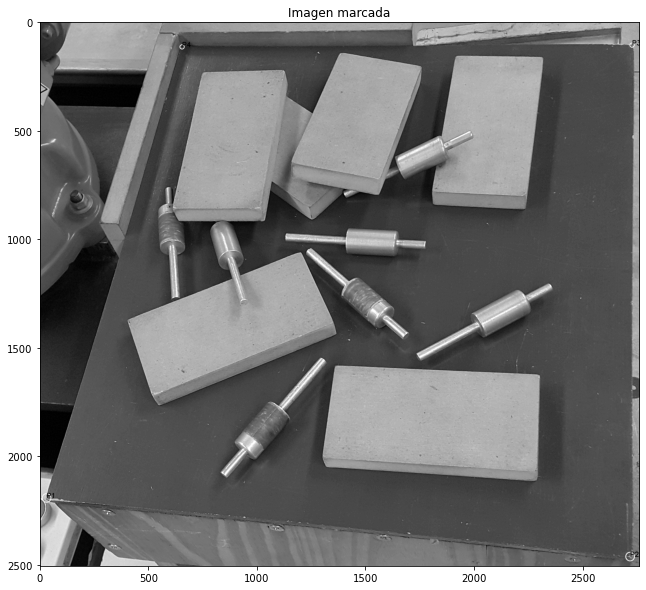

In [3]:
img_anota = img_gray.copy()

# Punto 1
p1=(30,2190)
cv.circle(img_anota,p1,20,(255,0,0),2,cv.LINE_AA)
cv.putText(img_anota,'P1',p1,cv.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2,cv.LINE_AA)

# Punto 2
p2=(2714,2460)
cv.circle(img_anota,p2,20,(255,0,0),2,cv.LINE_AA)
cv.putText(img_anota,'P2',p2,cv.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2,cv.LINE_AA)

# Punto 3
p3=(2723,106)
cv.circle(img_anota,p3,10,(255,0,0),2,cv.LINE_AA)
cv.putText(img_anota,'P3',p3,cv.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2,cv.LINE_AA)

# Punto 4
p4=(653,114)
cv.circle(img_anota,p4,10,(255,0,0),2,cv.LINE_AA)
cv.putText(img_anota,'P4',p4,cv.FONT_HERSHEY_SIMPLEX,1,(0,255,255),2,cv.LINE_AA)


# Graficamos...
#plt.figure("Imagen marcada")
plt.figure(figsize=(12,10))
plt.title("Imagen marcada")
plt.imshow(img_anota,cmap='gray')
plt.show()

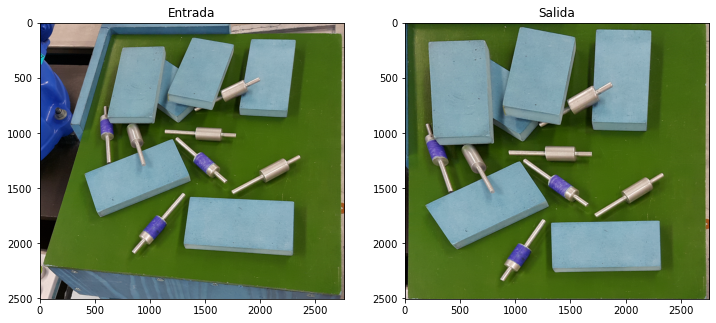

In [4]:
# Para la transformación proyectiva necesitamos cuatro puntos. Usamos los puntos P1, P2, P3 y P4 anteriormente definidos.
rows, cols = img.shape[:2]
# Puntos de origen
pts1 = np.float32([[p1[0],p1[1]],[p2[0],p2[1]],[p3[0],p3[1]],[p4[0],p4[1]]])
# Puntos de destino (adonde se mapean)
pts2 = np.float32([[30,2500],[2714,2500],[2714,0],[30,0]])

M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img,M,(cols,rows))

#plt.figure("Transformación Proyectiva")
plt.figure(figsize=(12,10))
plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Entrada')
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Salida')

plt.show()

### Binarizamos la imagen
+ Realizamos este procesamiento para luego poder utilizar el método de watersheed, ya que este recibe una imagen binarizada.

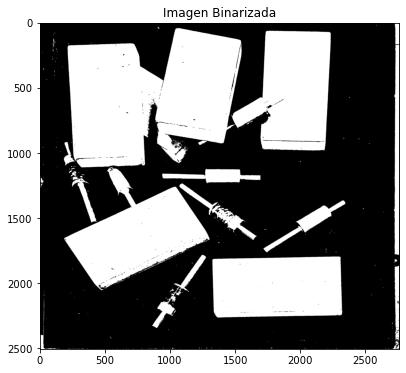

In [5]:
dst_gray=cv.cvtColor(dst,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(dst_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

#plt.figure("Imagen Binarizada")
plt.figure(figsize=(8,6))
plt.title("Imagen Binarizada")
plt.imshow(thresh, cmap="gray")
plt.show()

## Cierre

+ Realizamos la operación morfológica de cierre de manera tal que se "cierren" los huecos negros de la binarizacion sobre los bloques. De esta forma la imagen a procesar por watersheed se encuentra más limpia.

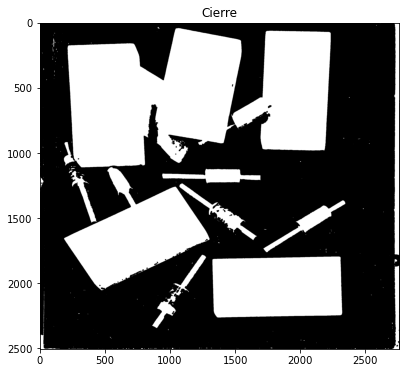

In [6]:
kernel = np.ones ((7,7), np.uint8)
cierre = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)

#plt.figure('Cierre')
plt.figure(figsize=(8,6))
plt.title("Cierre")
plt.imshow(cierre, cmap='gray')
plt.show()

# Watersheed

+ El algoritmo de watersheed consta de varias instancias:
    1. Definir las "semillas" en las que se enfoca watersheed para considerar objeto
    2. Marcar esas zonas
    3. Implementar la función cv.watershed() que proveé OpenCV

Distancia máxima de transformación:  317.0


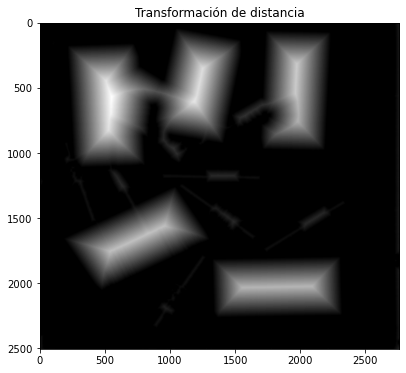

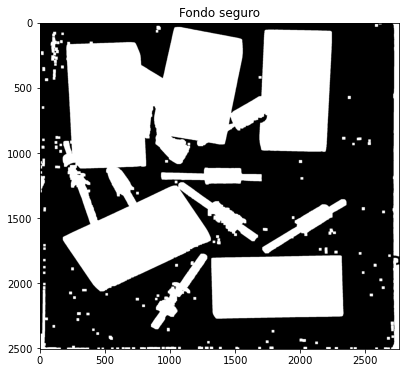

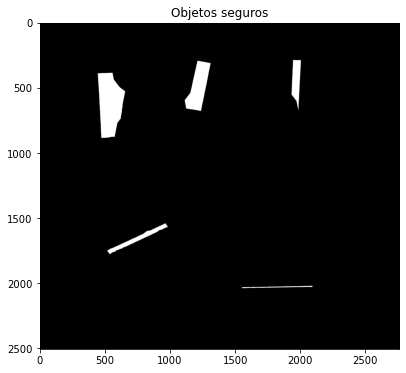

In [8]:
# Reducción de ruido
#kernel = np.ones((3,3),np.uint8)
#opening = cv.morphologyEx(cierre,cv.MORPH_OPEN,kernel, iterations = 2)
#plt.figure()
#plt.imshow(cierre,cmap='gray')

# Área de fondo (background) segura
sure_bg = cv.dilate(cierre,kernel,iterations=3)

# Búsqueda del área de objeto (foreground) segura --> Podría usar solo unaa erosion o la función distancia (para figuras que se tocan)

# MÉTODO 1: Solo erosión
#-----------------------
# sure_fg = cv.erode (opening, kernel, iterations = 3)

# MÉTODO 2: Transformación de distancia (distancia de cada píxel al cero más cercano)
#------------------------------------------------------------------------------------
# Conviene cerrar primero la figura para que no haya agujeros (ceros) dentro de los objetos que afecten la transformada
closing = cv.morphologyEx(cierre,cv.MORPH_CLOSE,kernel, iterations = 2)
# Ahora sí aplicamos la transformación de distancia
dist_transform = cv.distanceTransform(closing,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
print("Distancia máxima de transformación: ", dist_transform.max())

# Búsqueda de la región no definida
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

#Graficamos...
#=============
#plt.figure('Transformación de distancia')
plt.figure(figsize=(8,6))
plt.title("Transformación de distancia")
plt.imshow(dist_transform,cmap='gray')

#plt.figure('Fondo seguro')
plt.figure(figsize=(8,6))
plt.title("Fondo seguro")
plt.imshow(sure_bg,cmap='gray')

#plt.figure('Obejtos seguros')
plt.figure(figsize=(8,6))
plt.title("Objetos seguros")
plt.imshow(sure_fg,cmap='gray')

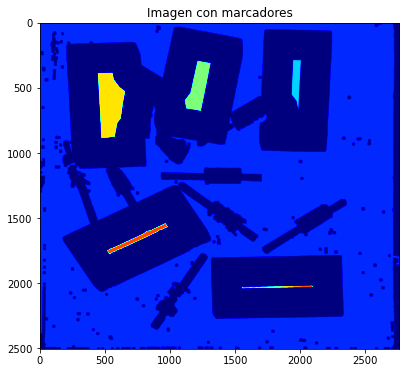

In [9]:
# Etiquetado de marcadores
ret, markers = cv.connectedComponents(sure_fg)
# Agregar un uno ('1') a todas las etiquetas (para evitar la etiqueta '0')
markers = markers+1
# Ahora, marcamos la región de incertezas con cero
markers[unknown==255] = 0

#plt.figure("Imagen con marcadores")
plt.figure(figsize=(8,6))
plt.title("Imagen con marcadores")
plt.imshow(markers,cmap='jet')

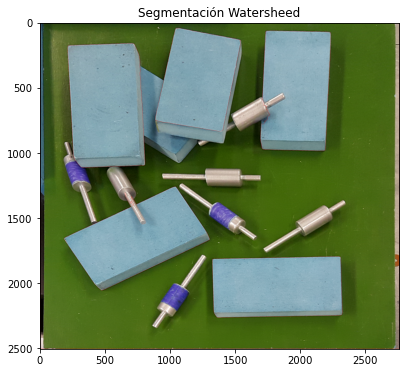

In [10]:
img_out_1 = dst.copy()
markers = cv.watershed(img_out_1,markers)
img_out_1[markers == -1] = [255,0,0]

#plt.figure("Segmentación Watersheed")
plt.figure(figsize=(8,6))
plt.title("Segmentación Watersheed")
plt.imshow(img_out_1,cmap='jet')

# Mean Shift

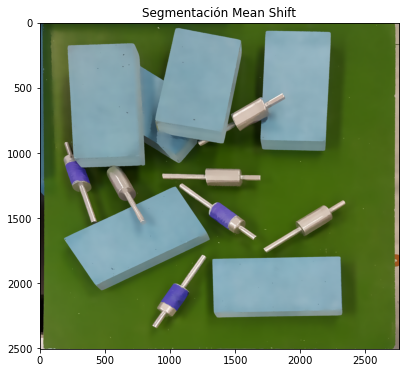

In [11]:
# Radio para la ventana espacial
sp = 20
# Radio para la ventana color
sr = 40

# Corremos el filtrado (segmentación)
img_out=cv.pyrMeanShiftFiltering(dst, sp, sr)

# Mostramos el resultado
#plt.figure("Segmentación Mean Shift")
plt.figure(figsize=(8,6))
plt.title("Segmentación Mean Shift")
plt.imshow(img_out)
plt.show()

# K-Means

In [12]:
# Cambiamos el tamaño a un array de Mx3 (con M el número de píxels). Es decir, un vector de M componentes por canal (R,G,B)
Z = dst.reshape((-1,3))
print('Dimensión de la matriz de características (colores): {}'.format(Z.shape))

# convert to np.float32
Z = np.float32(Z)

# Definimos el criterio de detención (Epsilon e iteraciones máximas) y número de clústers (K)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 7

# Corremos el algoritmo de K-means con:
# - El criterio de detención predefinido
# - 10 ejecuciones del algoritmo distintos parametros iniciales (devuelve los centros de la corrida que de grupos más compactos)
# - Parámetro de incialización de las semillas (aleatorio)
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

Dimensión de la matriz de características (colores): (6911040, 3)


Centros: 
 [[113 131 141]
 [135 171 184]
 [188 171 156]
 [ 43  66  13]
 [230 219 210]
 [ 85  98  92]
 [ 71 102  20]] 



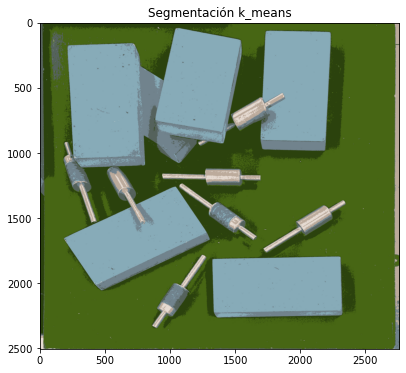

In [13]:
# Convertimos a uint8 y rearmamos la imagen original con los grupos hallados
#===========================================================================

# Mostramos los centros (colores) que forman cada grupo
center = np.uint8(center)
print('Centros: \n {} \n'.format(center))

# Cada píxel que corresponde a un grupo tiene copiado como etiqueta el color al que corresponde. Hacemos un reshape al tamaño original de la matriz de imagen 
img_out = center[label.flatten()]  
img_out = img_out.reshape((dst.shape))

# Mostramos la imagen compuest
#plt.figure("Segmentación K-means")
plt.figure(figsize=(8,6))
plt.title("Segmentación k_means")
plt.imshow(img_out)
plt.show()

## Análisis de Resultados y conclusiones
+ Como podemos observar los algoritmos cumplen con lo pedido y logran segmentar los bloques del resto de las piezas, siendo en Watersheed marcado los bordes con una línea roja, y tanto en K-Means como en Mean Shift segmentado por el espacio de colores puesto que todos los bloques tienen el mismo color.
 Asimismo planteamos tambien la posibilidad de combinar estos algoritmos dado que como mencionamos anteriormente el procesamiento de watersheed se utiliza para precomputar ls segmentación. De manera que la imagen obtenida luego del Watersheed la implementamos tanto en K-means como en Mean shift.


### Procesamiento luego de precomputo por watersheed

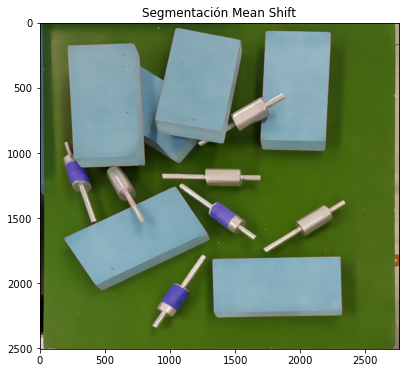

Dimensión de la matriz de características (colores): (6911040, 3)


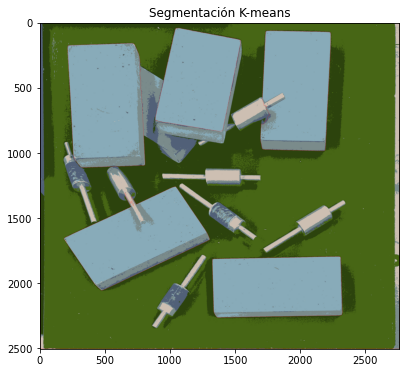

In [14]:
#traemos nuevamente la imagen de salida de watersheed
precomputo=img_out_1

# |Procesamos por Mean shift|
# ==========================

# Radio para la ventana espacial
sp = 20
# Radio para la ventana color
sr = 40

# Corremos el filtrado (segmentación)
img_mean_shift=cv.pyrMeanShiftFiltering(precomputo, sp, sr)

# Mostramos el resultado
#plt.figure("Segmentación Mean Shift")
plt.figure(figsize=(8,6))
plt.title("Segmentación Mean Shift")
plt.imshow(img_mean_shift)
plt.show()

# |Procesamos por K-Means|
# ========================

Z = precomputo.reshape((-1,3))
print('Dimensión de la matriz de características (colores): {}'.format(Z.shape))

# convert to np.float32
Z = np.float32(Z)

# Definimos el criterio de detención (Epsilon e iteraciones máximas) y número de clústers (K)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 7

# Corremos el algoritmo de K-means con:
# - El criterio de detención predefinido
# - 10 ejecuciones del algoritmo distintos parametros iniciales (devuelve los centros de la corrida que de grupos más compactos)
# - Parámetro de incialización de las semillas (aleatorio)
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)

# Cada píxel que corresponde a un grupo tiene copiado como etiqueta el color al que corresponde. Hacemos un reshape al tamaño original de la matriz de imagen 
img_out = center[label.flatten()]  
img_out = img_out.reshape((precomputo.shape))

# Mostramos la imagen compuesta
#plt.figure("Segmentación K-means")
plt.figure(figsize=(8,6))
plt.title("Segmentación K-means")
plt.imshow(img_out)
plt.show()



+ De esta manera obtenemos un resultado más claro que en los anteriores, dado que enfatizamos el marcar los bordes y segmentar la imagen por colores.